In [1]:
import pandas as pd
import json
import os

datasets_json = os.listdir("data")

In [2]:
datas = []

for json_file in datasets_json:
    with open(f"data/{json_file}", "r") as file:
        datas.append(json.load(file))

In [3]:
final_output = []

for season_obj in datas:
    for match_obj in season_obj["matches"]:
        for match in match_obj["matches"]:
            obj_to_append = match
            obj_to_append["date"] = match_obj["date_long"]
            obj_to_append["season"] = season_obj["season"]
            final_output.append(obj_to_append)

In [4]:
final_dataframe = pd.DataFrame(final_output)

In [5]:
final_dataframe["year"] = final_dataframe["date"].map(lambda x: x[-4:])

In [7]:
df = final_dataframe

In [8]:
final_dataframe.drop(columns=["competition", "status"], inplace=True)

In [9]:
final_dataframe.url.map(lambda x: x.startswith("//")).value_counts()

url
True    12266
Name: count, dtype: int64

In [10]:
final_dataframe["url"] = final_dataframe["url"].map(lambda x: x[2:])

In [11]:
final_dataframe["score"] = final_dataframe["score"].map(lambda x: x.replace("\n", ""))

In [12]:
def match_result(score: str) -> str:
    home_goals, away_goals = score.split("-")
    home_goals = int(home_goals)
    away_goals = int(away_goals)

    if home_goals > away_goals:
        return "home"
    elif away_goals > home_goals:
        return "away"
    else:
        return "draw"

In [13]:
final_dataframe["result"] = final_dataframe["score"].map(match_result)

In [15]:
final_dataframe[["home_goals", "away_goals"]] = (
    final_dataframe["score"].str.split("-", expand=True).astype(int)
)

In [16]:
df["kickoff_time"] = pd.to_datetime(df["kickoff_time"], unit="ms")

/tmp/ipykernel_222655/428580435.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["kickoff_time"] = pd.to_datetime(df["kickoff_time"], unit="ms")


In [17]:
df

,home_team,away_team,stadium,match_id,kickoff_time,score,url,date,season,year,result,home_goals,away_goals
0,Arsenal,Stoke,"Emirates Stadium, London",6697,2009-05-24 15:00:00,4-1,www.premierleague.com/match/6697,Sunday 24 May 2009,2008/09,2009,home,4,1
1,Aston Villa,Newcastle,"Villa Park, Birmingham",6698,2009-05-24 15:00:00,1-0,www.premierleague.com/match/6698,Sunday 24 May 2009,2008/09,2009,home,1,0
2,Blackburn,West Brom,"Ewood Park, Blackburn",6699,2009-05-24 15:00:00,0-0,www.premierleague.com/match/6699,Sunday 24 May 2009,2008/09,2009,draw,0,0
3,Fulham,Everton,"Craven Cottage, London",6700,2009-05-24 15:00:00,0-2,www.premierleague.com/match/6700,Sunday 24 May 2009,2008/09,2009,away,0,2
4,Hull,Man Utd,"KCOM Stadium, Hull",6701,2009-05-24 15:00:00,0-1,www.premierleague.com/match/6701,Sunday 24 May 2009,2008/09,2009,away,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12261,Man Utd,Leicester,"Old Trafford, Manchester",2530,1998-08-15 14:00:00,2-2,www.premierleague.com/match/2530,Saturday 15 August 1998,1998/99,1998,draw,2,2
12262,Middlesbrough,Leeds,"Riverside Stadium, Middlesbrough",2531,1998-08-15 14:00:00,0-0,www.premierleague.com/match/2531,Saturday 15 August 1998,1998/99,1998,draw,0,0
12263,Newcastle,Charlton,"St. James' Park, Newcastle",2532,1998-08-15 14:00:00,0-0,www.premierleague.com/match/2532,Saturday 15 August 1998,1998/99,1998,draw,0,0
12264,Sheffield Wed,West Ham,"Hillsborough, Sheffield",2533,1998-08-15 14:00:00,0-1,www.premierleague.com/match/2533,Saturday 15 August 1998,1998/99,1998,away,0,1


In [18]:
df.isnull().sum()

home_team       0
away_team       0
stadium         0
match_id        0
kickoff_time    0
score           0
url             0
date            0
season          0
year            0
result          0
home_goals      0
away_goals      0
dtype: int64

In [19]:
print("Total matches:", len(df))
print("Unique teams:", df["home_team"].nunique())
print("Seasons:", df["season"].nunique())

Total matches: 12266
Unique teams: 51
Seasons: 33


<Axes: title={'center': 'Match Results Distribution'}, xlabel='result'>

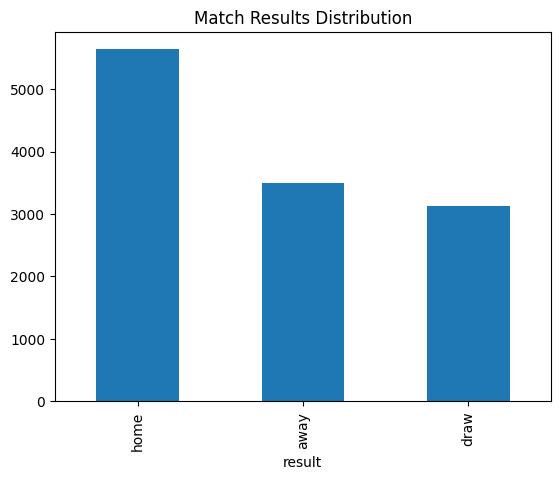

In [20]:
df["result"].value_counts().plot(kind="bar", title="Match Results Distribution")

In [21]:
print("Average home goals:", df["home_goals"].mean())
print("Average away goals:", df["away_goals"].mean())

Average home goals: 1.5348932007174303
Average away goals: 1.158486874286646


In [22]:
df["home_points"] = df["result"].apply(
    lambda x: 3 if x == "home" else (1 if x == "draw" else 0)
)
df["away_points"] = df["result"].apply(
    lambda x: 3 if x == "away" else (1 if x == "draw" else 0)
)

In [23]:
home_points = df.groupby("home_team")["home_points"].sum()
away_points = df.groupby("away_team")["away_points"].sum()
total_points = home_points.add(away_points, fill_value=0)

In [24]:
home_advantage = (home_points.sum() / len(df)) - (away_points.sum() / len(df))
print("Home Advantage (Average Points per Match):", home_advantage)

Home Advantage (Average Points per Match): 0.5219305397032445


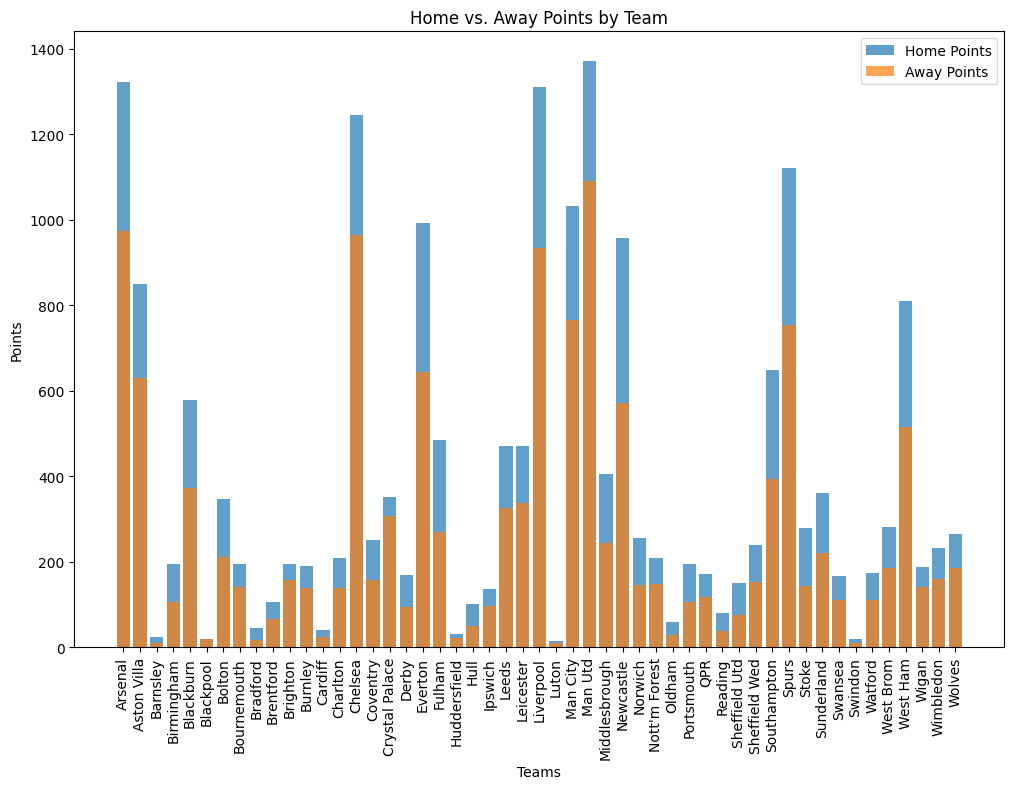

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.bar(home_points.index, home_points, label="Home Points", alpha=0.7)
plt.bar(away_points.index, away_points, label="Away Points", alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel("Teams")
plt.ylabel("Points")
plt.title("Home vs. Away Points by Team")
plt.legend()
plt.show()

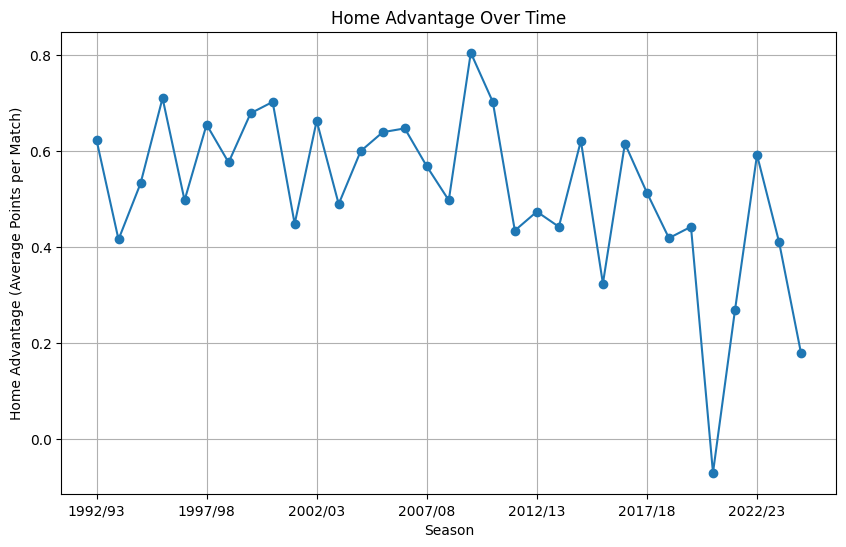

In [29]:
home_advantage_by_season = df.groupby("season").apply(
    lambda x: (x["home_points"].sum() / len(x)) - (x["away_points"].sum() / len(x)),
    include_groups=False
)

plt.figure(figsize=(10, 6))
home_advantage_by_season.plot(kind="line", marker="o")
plt.xlabel("Season")
plt.ylabel("Home Advantage (Average Points per Match)")
plt.title("Home Advantage Over Time")
plt.grid(True)
plt.show()

'2025'

In [39]:
DATE_RANGE = f"{df["year"].min()}-{df["year"].max()}"

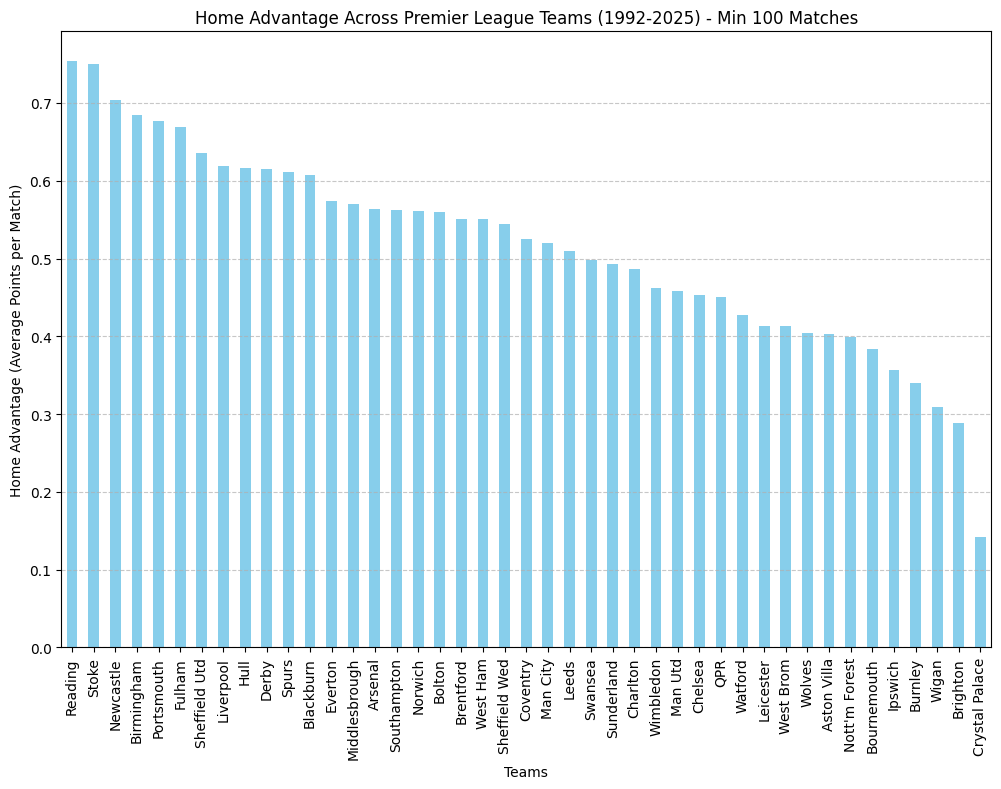

In [40]:
MINIMUM_MATCHES = 100

home_matches = df["home_team"].value_counts()
away_matches = df["away_team"].value_counts()

total_matches = home_matches.add(away_matches, fill_value=0)
filtered_teams = total_matches[total_matches >= MINIMUM_MATCHES].index
avg_home_points = home_points[filtered_teams] / home_matches[filtered_teams]
avg_away_points = away_points[filtered_teams] / away_matches[filtered_teams]
home_advantage_filtered = avg_home_points - avg_away_points
home_advantage_filtered_sorted = home_advantage_filtered.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
home_advantage_filtered_sorted.plot(kind="bar", color="skyblue")
plt.xlabel("Teams")
plt.ylabel("Home Advantage (Average Points per Match)")
plt.title(
    f"Home Advantage Across Premier League Teams ({DATE_RANGE}) - Min {MINIMUM_MATCHES} Matches"
)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [37]:
df["away_team"]

0            Stoke
1        Newcastle
2        West Brom
3          Everton
4          Man Utd
           ...    
12261    Leicester
12262        Leeds
12263     Charlton
12264     West Ham
12265        Spurs
Name: away_team, Length: 12266, dtype: object

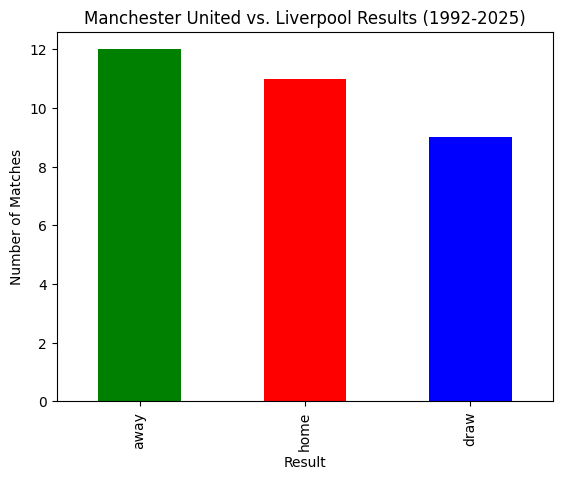

In [41]:
# Filter matches between Manchester United and Liverpool
rivalry_matches = df[
    ((df["home_team"] == "Manchester United") & (df["away_team"] == "Liverpool"))
    | ((df["home_team"] == "Liverpool") & (df["away_team"] == "Man Utd"))
]

# Calculate results
rivalry_results = rivalry_matches["result"].value_counts()

# Plot results
rivalry_results.plot(kind="bar", color=["green", "red", "blue"])
plt.xlabel("Result")
plt.ylabel("Number of Matches")
plt.title(f"Manchester United vs. Liverpool Results ({DATE_RANGE})")
plt.show()

<Figure size 1200x800 with 0 Axes>

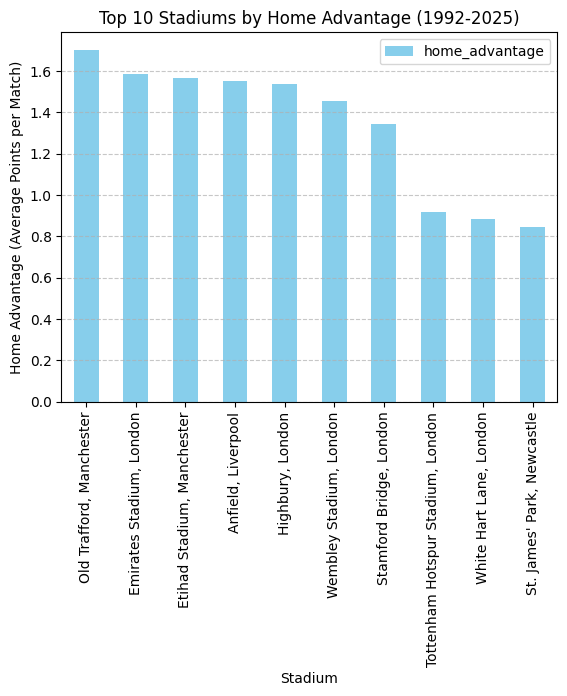

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by stadium and calculate home performance
stadium_stats = (
    df.groupby("stadium")
    .agg(
        total_home_points=("home_points", "sum"),
        total_home_matches=("home_team", "count"),
        avg_home_points=("home_points", "mean"),
        win_rate=("result", lambda x: (x == "home").mean()),
        avg_home_goals=("home_goals", "mean"),
    )
    .reset_index()
)

# Group by stadium and calculate away performance
away_stats = (
    df.groupby("stadium")
    .agg(
        total_away_points=("away_points", "sum"),
        total_away_matches=("away_team", "count"),
        avg_away_points=("away_points", "mean"),
        away_win_rate=("result", lambda x: (x == "away").mean()),
        avg_away_goals=("away_goals", "mean"),
    )
    .reset_index()
)

# Merge home and away stats
stadium_impact = pd.merge(stadium_stats, away_stats, on="stadium")

# Calculate stadium impact metrics
stadium_impact["home_advantage"] = (
    stadium_impact["avg_home_points"] - stadium_impact["avg_away_points"]
)
stadium_impact["goal_difference"] = (
    stadium_impact["avg_home_goals"] - stadium_impact["avg_away_goals"]
)

# Sort stadiums by home advantage
stadium_impact_sorted = stadium_impact.sort_values(by="home_advantage", ascending=False)

# Plot top 10 stadiums by home advantage
plt.figure(figsize=(12, 8))
stadium_impact_sorted.head(10).plot(
    kind="bar", x="stadium", y="home_advantage", color="skyblue"
)
plt.xlabel("Stadium")
plt.ylabel("Home Advantage (Average Points per Match)")
plt.title(f"Top 10 Stadiums by Home Advantage ({DATE_RANGE})")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare features and target
X = df[
    ["home_team", "away_team", "home_goals", "away_goals"]
]  # Add more features as needed
y = df["result"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

ValueError: could not convert string to float: "Nott'm Forest"